# Radial Velocities
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 3/2/2022|

See JY07, Fig. 16

In [1]:
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pwd = '../unstrat/'

## Time Variability

In [7]:
runs = ['AB', 'BA']
Pis = [['0.01', 'tab:blue'], ['0.02', 'tab:green'],
       ['0.05', 'tab:orange'], ['0.10', 'tab:red']]
res = '2048'
n_bins = 50
arrays, vpx0s, avg_vpxs, std_vpxs = [[], []], [], [], []
t_sats = [2.0, 20.0]
jy07_vpxs = [0, 0, -0.108, 0, 0, 0, -0.52, 0]

for i,run in enumerate(runs):
    for Pi in Pis:
        path = '../unstrat/%s/%s/%s/'%(run, Pi[0], res)
        athinput = athena_read.athinput(path+'athinput.si')
        i_sat = int(t_sats[i]/athinput['output3']['dt'])
        if run=='AB' and Pi[0]=='0.01':
            i_sat = int(4.0/athinput['output3']['dt'])
        etav_K = float(Pi[0])*athinput['hydro']['iso_sound_speed']
        hst = athena_read.hst(path+'output/SI.hst')
        Np = athinput['problem']['npx1']*athinput['problem']['npx2']\
             *athinput['problem']['npx3']

        arrays[0].append(run)
        arrays[1].append(Pi[0])
        vpx0s.append(hst['vp1'][0]/etav_K/Np)
        avg_vpxs.append(np.average(hst['vp1'][i_sat:])/Np/etav_K)
        std_vpxs.append(np.std(hst['vp1'][i_sat:])/Np/etav_K)

tuples = list(zip(*arrays))
names = ['Case', '$\Pi$']
index = pd.MultiIndex.from_tuples(tuples, names=names)
df = pd.DataFrame({r'$v_{\textrm{p},x,0}$'              : vpx0s,
                   r'$\overline{v_x}$'                  : jy07_vpxs,
                   r'$\langle v_{\textrm{p},x}\rangle$' : avg_vpxs,
                   r'$\sigma_{v_{\textrm{p},x}}$'       : std_vpxs,},
                  index=index)
df.style.format({r'$v_{\textrm{p},x,0}$'              : '{:.3f}',
                 r'$\overline{v_x}$'                  : '{:.3f}',
                 r'$\langle v_{\textrm{p},x}\rangle$' : '{:.3f}',
                 r'$\sigma_{v_{\textrm{p},x}}$'       : '{:.3f}'})

## Radial Dust Velocities (Last Snapshot)

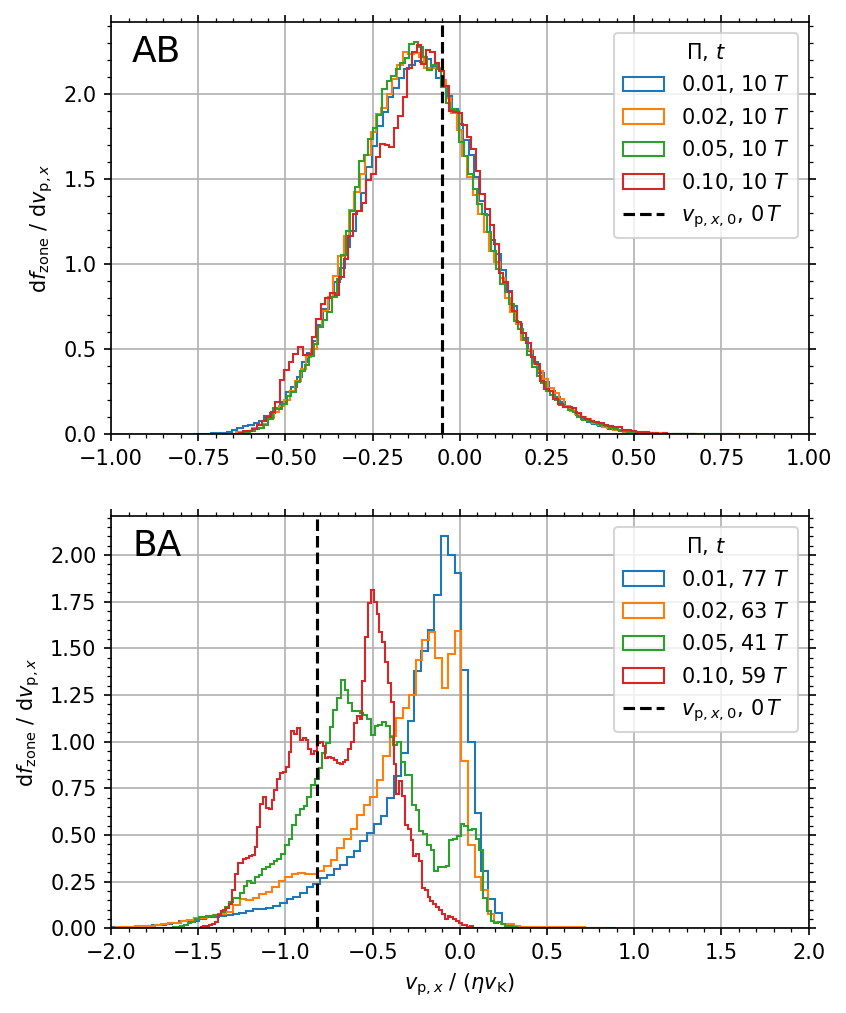

In [12]:
from pathlib import Path

fig, axs = plt.subplots(2, 1, figsize=(6,8), dpi=150)
runs = ['AB', 'BA']
Pis = [['0.01', 'tab:blue'], ['0.02', 'tab:green'],
       ['0.05', 'tab:orange'], ['0.10', 'tab:red']]
res = '2048'
xlims = [(-1.0, 1.0), (-2.0, 2.0)]
n_bins = 100
arrays, avgvpxs = [[], []], []
t_sats = [2.0, 20.0]

for i,ax in enumerate(axs.flat):
    for Pi in Pis:
        path = pwd+'%s/%s/%s/'%(runs[i], Pi[0], res)
        athinput = athena_read.athinput(path+'athinput.si')
        i_sat = int(t_sats[i]/athinput['output1']['dt'])
        if runs[i]=='AB' and Pi[0]=='0.01':
            i_sat = int(4.0/athinput['output1']['dt'])
        etav_K = float(Pi[0])*athinput['hydro']['iso_sound_speed']
        hst = athena_read.hst(path+'output/SI.hst')
        Np = athinput['problem']['npx1']*athinput['problem']['npx2']\
             *athinput['problem']['npx3']
        vpx0 = hst['vp1'][0]/etav_K/Np
        outputs = sorted(list(Path(path+'athdf').glob(
                  athinput["job"]["problem_id"]+'.out1.*.athdf')))
        output = outputs[-1] # last snapshot
        data = athena_read.athdf(output)
        vpxs = data['vp1'].flatten()
        rhops = data['rhop'].flatten()
        t = data['Time']

        arrays[0].append(runs[i])
        arrays[1].append(Pi[0])
        avgvpxs.append(np.average(vpxs, weights=rhops)/etav_K)
        ax.hist(vpxs/etav_K, bins=n_bins, density=True, weights=rhops,
                histtype='step', label=r'{:s}, {:.0f} $T$'.format(Pi[0], t))

    ax.axvline(vpx0, c='black', ls='--', label=r'$v_{\mathrm{p},x,0},\,0\,T$')
    ax.grid()
    ax.legend(loc='upper right', title=r'$\Pi,\,t$')
    ax.minorticks_on()
    ax.set(xlim=xlims[i], ylabel=r'd$f_\mathrm{zone}$ / d$v_{\mathrm{p},x}$')
    ax.text(0.03, 0.97, runs[i], ha='left', va='top', size='xx-large',
            transform=ax.transAxes)
    ax.tick_params(which='both', top=True, right=True)

ax.set(xlabel=r'$v_{\mathrm{p},x}$ / $(\eta v_\mathrm{K})$')
# plt.savefig('scripts/figs/vpxd2.pdf', bbox_inches='tight', pad_inches=0.01)

tuples = list(zip(*arrays))
names = ['Case', '$\Pi$']
index = pd.MultiIndex.from_tuples(tuples, names=names)

df = pd.DataFrame({r'$\langle v_{\textrm{p},x} \rangle$':avgvpxs}, index=index)
df.style.format({r'$\langle v_{\textrm{p},x} \rangle$':'{:.3f}'})

## Density-weighted Zonal Distribution

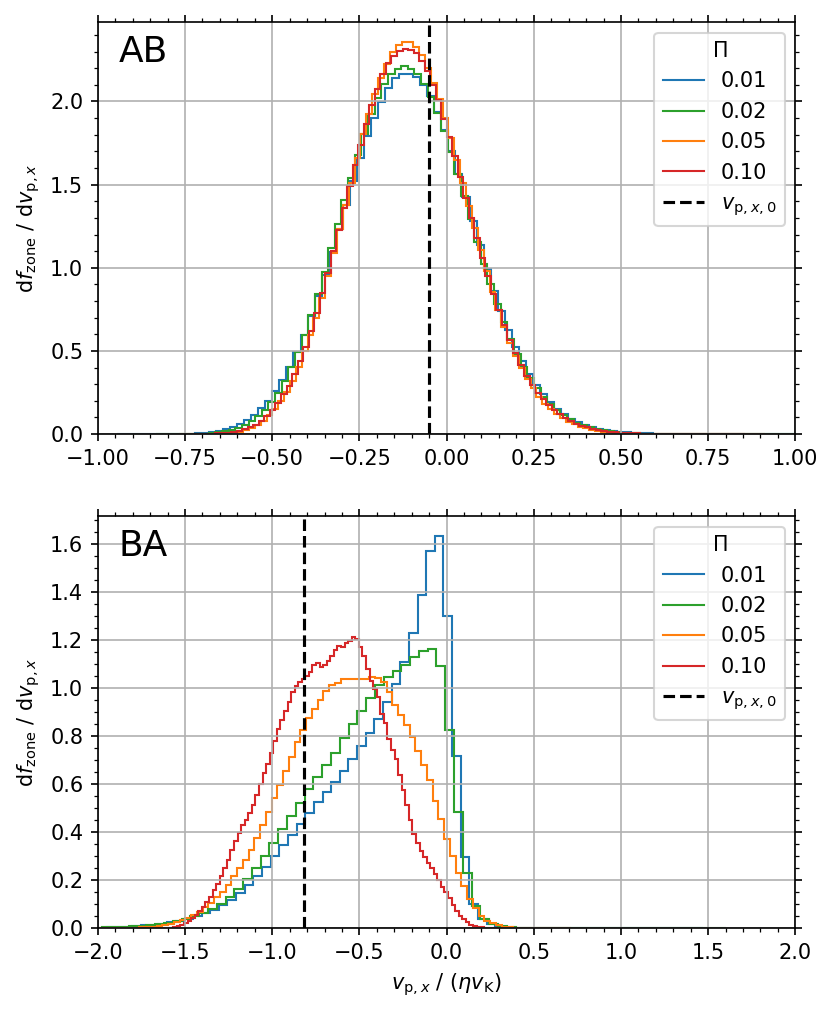

In [7]:
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

workdir = '../unstrat/'

fig, axs = plt.subplots(2, 1, figsize=(6,8), dpi=150)
runs = ['AB', 'BA']
Pis = [['0.01', 'tab:blue'], ['0.02', 'tab:green'],
       ['0.05', 'tab:orange'], ['0.10', 'tab:red']]
res = '2048'
xlims = [(-1.0, 1.0), (-2.0, 2.0)]
indcols = [[], []]             # Case, Pi
datcols = [[], [], [], [], []] # vpx0, avg, var, skew, kurt

for i,ax in enumerate(axs.flat):
    for Pi in Pis:
        path = workdir+'%s/%s/%s/'%(runs[i], Pi[0], res)
        athinput = athena_read.athinput(path+'athinput.si')
        etav_K = float(Pi[0])*athinput['hydro']['iso_sound_speed']
        hst = athena_read.hst(path+'output/SI.hst')
        Np = athinput['problem']['npx1']*athinput['problem']['npx2']\
             *athinput['problem']['npx3']
        vpx0 = hst['vp1'][0]/etav_K/Np
        datcols[0].append(vpx0)

        with np.load(path+'output/vpxd.npz') as data:
            indcols[0].append(runs[i])
            indcols[1].append(Pi[0])
            datcols[1].append(data['wavg'])
            datcols[2].append(data['wvar'])
            datcols[3].append(data['wskew'])
            datcols[4].append(data['wkurt'])
            ax.stairs(data['hist'], data['bin_edges'], label=f'{Pi[0]:s}',
                      color=Pi[1])

    ax.axvline(vpx0, c='black', ls='--', label=r'$v_{\mathrm{p},x,0}$')
    ax.grid()
    ax.legend(loc='upper right', title=r'$\Pi$')
    ax.minorticks_on()
    ax.set(xlim=xlims[i], ylabel=r'd$f_\mathrm{zone}$ / d$v_{\mathrm{p},x}$')
    ax.text(0.03, 0.97, runs[i], ha='left', va='top', size='xx-large',
            transform=ax.transAxes)
    ax.tick_params(which='both', top=True, right=True)

tuples = list(zip(*indcols))
names = ['Case', r'$\Pi$']
index = pd.MultiIndex.from_tuples(tuples, names=names)
df = pd.DataFrame({  r'$v_{\textrm{p},x,0}'              : datcols[0],
                     r'$\langle v_{\textrm{p},x}\rangle' : datcols[1],
                     r'$\sigma_{v_{\textrm{p},x}}^2$'    : datcols[2],
                     r'Skew'                             : datcols[3],
                     r'Kurt'                             : datcols[4]},
                  index=index)
s = df.style.format({r'$v_{\textrm{p},x,0}'              : '{:.3f}',
                     r'$\langle v_{\textrm{p},x}\rangle' : '{:.3f}',
                     r'$\sigma_{v_{\textrm{p},x}}^2$'    : '{:.3f}',
                     r'Skew'                             : '{:.3f}',
                     r'Kurt'                             : '{:.3f}'})

s.to_latex(buf='tabs/vpxd.txt')
ax.set(xlabel=r'$v_{\mathrm{p},x}$ / $(\eta v_\mathrm{K})$')
plt.savefig('figs/vpxd.pdf', bbox_inches='tight', pad_inches=0.01)
plt.savefig('figs/vpxd.png', bbox_inches='tight', pad_inches=0.01)

## Particle Distribution

IndexError: list index out of range

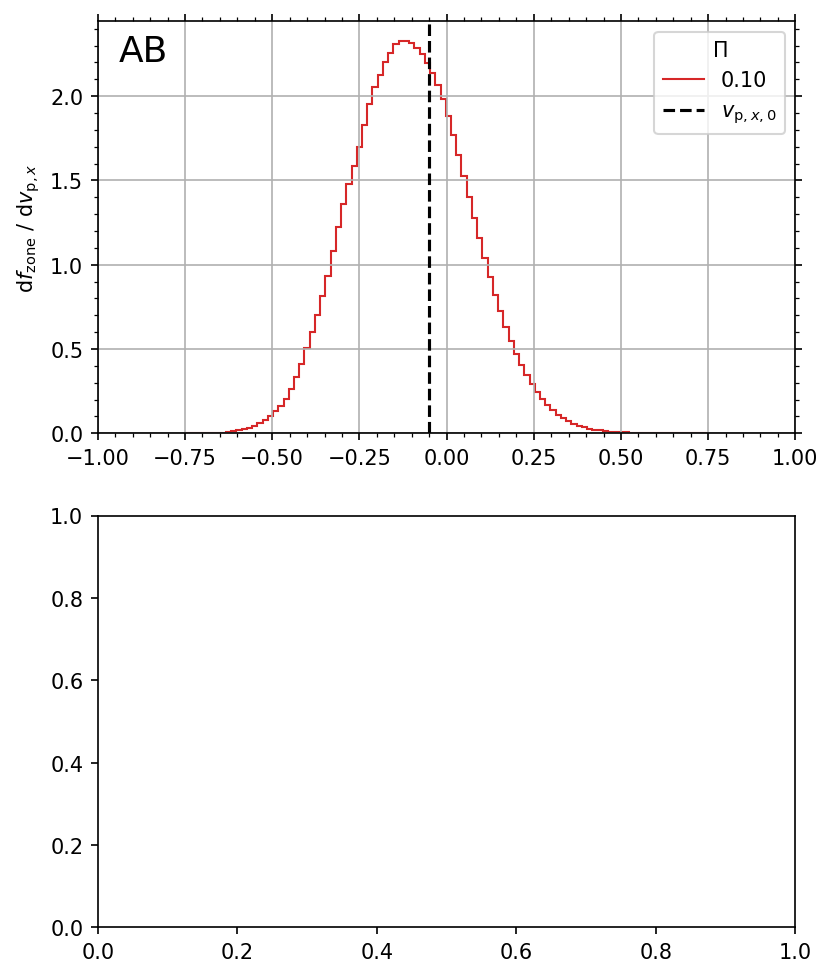

In [4]:
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

workdir = '../unstrat/'
runs = ['AB']#, 'BA']
Pis = [['0.01', 'tab:blue'], ['0.02', 'tab:green'],
       ['0.05', 'tab:orange'], ['0.10', 'tab:red']]
res = '2048'
xlims = [(-1.0, 1.0), (-2.0, 2.0)]
indcols = [[], []]             # Case, Pi
datcols = [[], [], [], [], []] # vpx0, mean, var, skew, kurt
fig, axs = plt.subplots(2, 1, figsize=(6,8), dpi=150)

for i,ax in enumerate(axs.flat):
    for Pi in Pis:
        path = workdir+'%s/%s/%s/'%(runs[i], Pi[0], res)
        athinput = athena_read.athinput(path+'athinput.si')
        etav_K = float(Pi[0])*athinput['hydro']['iso_sound_speed']
        hst = athena_read.hst(path+'output/SI.hst')
        Np = athinput['problem']['npx1']*athinput['problem']['npx2']\
             *athinput['problem']['npx3']
        vpx0 = hst['vp1'][0]/etav_K/Np
        datcols[0].append(vpx0)

        with np.load(path+'output/vpxd2.npz') as data:
            indcols[0].append(runs[i])
            indcols[1].append(Pi[0])
            datcols[1].append(data['mean'])
            datcols[2].append(data['var'])
            datcols[3].append(data['skew'])
            datcols[4].append(data['kurt'])
            ax.stairs(data['hist'], data['bin_edges'], label=f'{Pi[0]:s}',
                      color=Pi[1])

    ax.axvline(vpx0, c='black', ls='--', label=r'$v_{\mathrm{p},x,0}$')
    ax.grid()
    ax.legend(loc='upper right', title=r'$\Pi$')
    ax.minorticks_on()
    ax.set(xlim=xlims[i], ylabel=r'd$f_\mathrm{zone}$ / d$v_{\mathrm{p},x}$')
    ax.text(0.03, 0.97, runs[i], ha='left', va='top', size='xx-large',
            transform=ax.transAxes)
    ax.tick_params(which='both', top=True, right=True)

tuples = list(zip(*indcols))
names = ['Case', r'$\Pi$']
index = pd.MultiIndex.from_tuples(tuples, names=names)
df = pd.DataFrame({  r'$v_{\textrm{p},x,0}'              : datcols[0],
                     r'$\langle v_{\textrm{p},x}\rangle' : datcols[1],
                     r'$\sigma_{v_{\textrm{p},x}}^2$'    : datcols[2],
                     r'Skew'                             : datcols[3],
                     r'Kurt'                             : datcols[4]},
                  index=index)
s = df.style.format({r'$v_{\textrm{p},x,0}'              : '{:.3f}',
                     r'$\langle v_{\textrm{p},x}\rangle' : '{:.3f}',
                     r'$\sigma_{v_{\textrm{p},x}}^2$'    : '{:.3f}',
                     r'Skew'                             : '{:.3f}',
                     r'Kurt'                             : '{:.3f}'})

s.to_latex(buf='tabs/vpxd.txt')
ax.set(xlabel=r'$v_{\mathrm{p},x}$ / $(\eta v_\mathrm{K})$')
plt.savefig('figs/vpxd2.pdf', bbox_inches='tight', pad_inches=0.01)
plt.savefig('figs/vpxd2.png', bbox_inches='tight', pad_inches=0.01)

### Descriptions
- [Examples of skewness](https://en.wikipedia.org/wiki/Skewness#Examples), e.g., exponential distribution
- [Excess kurtosis](https://en.wikipedia.org/wiki/Kurtosis#Excess_kurtosis), e.g., mesokurtic, leptokurtic, platykurtic.

## Old

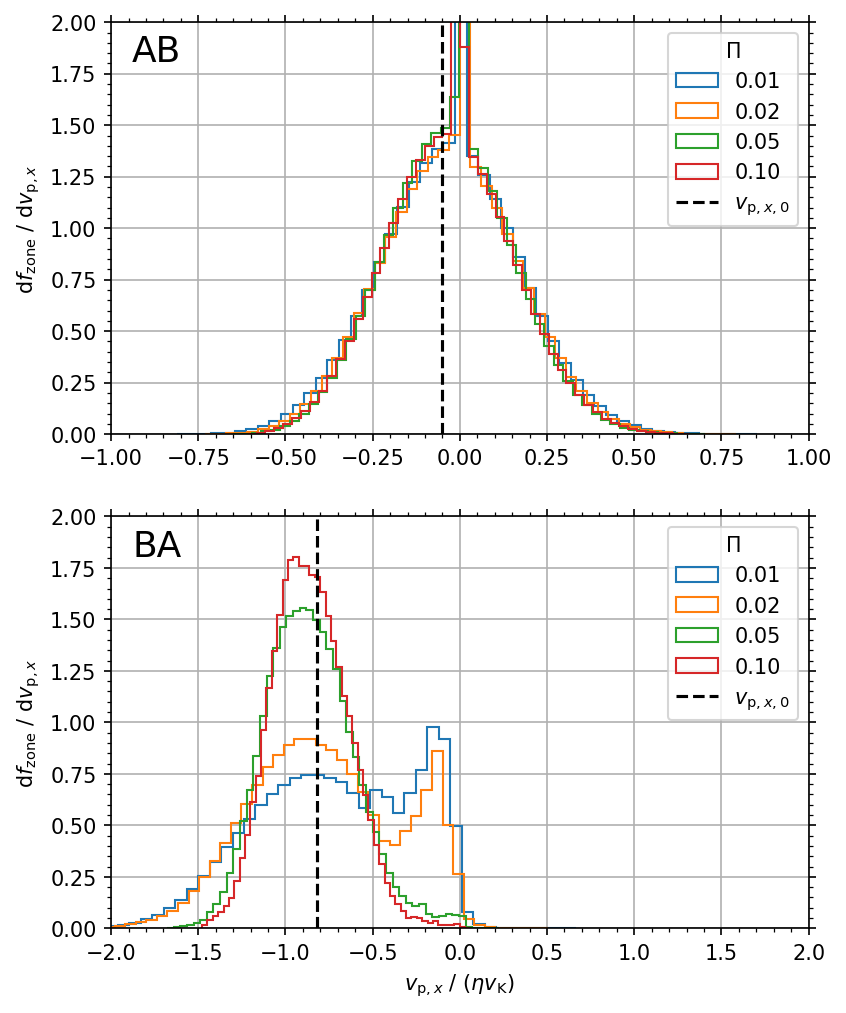

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(6,8), dpi=150)
runs = ['AB', 'BA']
Pis = [['0.01', 'tab:blue'], ['0.02', 'tab:green'],
       ['0.05', 'tab:orange'], ['0.10', 'tab:red']]
res = '2048'
xlims = [(-1.0, 1.0), (-2.0, 2.0)]
n_bins = 50
arrays, vpx0s, avgvpxs, oldvpxs = [[], []], [], [], []
t_sats = [2.0, 20.0]                                     # remove for PaperFigs

for i,ax in enumerate(axs.flat):
    for Pi in Pis:
        path = pwd+'%s/%s/%s/'%(runs[i], Pi[0], res)
        athinput = athena_read.athinput(path+'athinput.si')
        i_sat = int(t_sats[i]/athinput['output3']['dt']) # remove for PaperFigs
        if runs[i]=='AB' and Pi[0]=='0.01':
            i_sat = int(4.0/athinput['output3']['dt'])
        etav_K = float(Pi[0])*athinput['hydro']['iso_sound_speed'] # remove for PaperFigs
        hst = athena_read.hst(path+'output/SI.hst')
        Np = athinput['problem']['npx1']*athinput['problem']['npx2']*athinput['problem']['npx3'] # remove for PaperFigs
        vpx0 = hst['vp1'][0]/etav_K/Np
        oldvpx = np.average(hst['vp1'][i_sat:])/etav_K/Np # remove for PaperFigs

        with np.load(path+'output/vxs.npz') as data:
            vpxs = data['avgs']/etav_K

            arrays[0].append(runs[i])
            arrays[1].append(Pi[0])
            vpx0s.append(vpx0)
            avgvpxs.append(np.average(vpxs))
            oldvpxs.append(oldvpx)                         # remove for PaperFigs
            ax.hist(vpxs, bins=n_bins, density=True, histtype='step', label=Pi[0])

    ax.axvline(vpx0, c='black', ls='--', label=r'$v_{\mathrm{p},x,0}$')
    ax.grid()
    ax.legend(loc='upper right', title=r'$\Pi$')
    ax.minorticks_on()
    ax.set(xlim=xlims[i], ylim=(0, 2.0),
               ylabel=r'd$f_\mathrm{zone}$ / d$v_{\mathrm{p},x}$')
    ax.text(0.03, 0.97, runs[i], ha='left', va='top', size='xx-large',
                transform=ax.transAxes)
    ax.tick_params(which='both', top=True, right=True)

ax.set(xlabel=r'$v_{\mathrm{p},x}$ / $(\eta v_\mathrm{K})$')

tuples = list(zip(*arrays))
names = ['Case', '$\Pi$']
index = pd.MultiIndex.from_tuples(tuples, names=names)
df = pd.DataFrame({
     r'$v_{\textrm{p},x,0}$'   : vpx0s,
     r'$v_{\textrm{p},x}$'     : avgvpxs,
     r'Old $v_{\textrm{p},x}$' : oldvpxs},                # remove for PaperFigs
     index=index)
df.style.format({
    r'$v_{\textrm{p},x,0}$'   : '{:.3f}',
    r'$v_{\textrm{p},x}$'     : '{:.3f}',
    r'Old $v_{\textrm{p},x}$' : '{:.3f}'})               # remove for PaperFigs

## Scratch

In [14]:
n = 2
print(f'{n:02}')

02


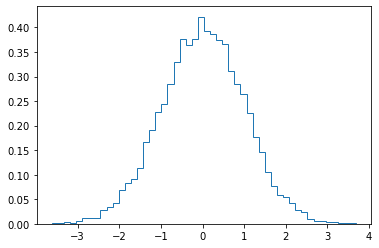

In [24]:
rng = np.random.RandomState(10) # reproducible seed
a = rng.normal(size=10000)
h, edges = np.histogram(a, bins=50, density=True)

plt.stairs(h, edges)

In [9]:
a1 = []
a1.append(np.arange(2))
a1.append(np.arange(2,4))
a2 = a1
np.asarray(a1)*np.asarray(a2)

array([[0, 1],
       [4, 9]])

In [10]:
a = np.arange(5)
a/np.sum()

array([0, 1, 2, 3, 4])

In [11]:
etav_K = 0.628
vpxs = []
vpxs.append(np.arange(2))
vpxs.append(np.arange(2,4))
print(vpxs)
np.asarray(vpxs)/etav_K

[array([0, 1]), array([2, 3])]


array([[0.        , 1.59235669],
       [3.18471338, 4.77707006]])